# **Engine Failure Detection Project**

**Dataset Overview:**  
The dataset used in this notebook includes various operational and sensor measurements collected from industrial engines. These measurements include parameters such as **torque**, **rotational speed**, **tool wear**, and the **type of failure** (if any).

**Objective:**  
The main goal of this notebook is to **develop a machine learning model** that can accurately **predict engine failures**.

# **Python Library used**

In [6]:
import numpy as np 
import pandas as pd
import math
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir(r"C:\Users\Lucas\Desktop\project\data")

# Preprocessing

In [7]:
df = pd.read_csv("CIA-1 Dataset.csv")

df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Vibration Levels           float64
Operational Hours          float64
Failure Type                object
dtype: object

In [8]:
df.drop(columns=['UDI','Product ID'], inplace=True)

df['diff_temp'] = df['Process temperature [K]'] - df['Air temperature [K]'] #we're creating a variable to account for the temperature gap between the engine and the air temperature

df_num = df[['Air temperature [K]','Process temperature [K]','diff_temp','Rotational speed [rpm]','Torque [Nm]','Vibration Levels ' ,'Operational Hours']] #selection of numerical variable 

df_num['FailureNumType'] = df['Failure Type'].replace({  # We're turning our categorical variable into numerical data for analysis' sake
    "No Failure": 0,
    "Power Failure": 1,
    "Tool Wear Failure": 2,
    "Overstrain Failure": 3
})

df_num['Failurebinary'] = df['Failure Type'].replace({  # We're turning our categorical variable into numerical data for analysis' sake
    "No Failure": 0,
    "Power Failure": 1,
    "Tool Wear Failure": 1,
    "Overstrain Failure": 1
})

df_num['MotorType'] = df['Type'].replace({
    "M": 0,
    "L": 1,
    "H": 2,
})



# Descriptive Statistic

In [9]:
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type,diff_temp
0,M,298.1,308.6,1551,42.8,42.0,20.00,No Failure,10.5
1,L,298.2,308.7,1408,46.3,52.0,21.00,No Failure,10.5
2,L,298.1,308.5,1498,49.4,44.0,18.00,No Failure,10.4
3,L,298.2,308.6,1433,39.5,52.0,10.00,No Failure,10.4
4,L,298.2,308.7,1408,40.0,44.0,10.00,No Failure,10.5
...,...,...,...,...,...,...,...,...,...
495,H,297.5,309.3,1459,49.7,45.0,163.91,No Failure,11.8
496,M,297.5,309.2,1530,40.0,55.0,164.26,No Failure,11.7
497,L,297.4,309.0,1505,39.2,45.0,164.62,No Failure,11.6
498,L,297.5,309.1,1611,30.2,34.0,164.97,No Failure,11.6


In [10]:
df_num.drop(columns=['FailureNumType','Failurebinary','MotorType']).describe()

,Air temperature [K],Process temperature [K],diff_temp,Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,298.097800,308.576400,10.478600,1540.494000,39.882800,36.904811,81.106840
std,0.563071,0.345372,0.529796,193.658248,9.768592,9.242797,45.904853
min,297.200000,307.900000,9.600000,1208.000000,4.200000,23.000000,10.000000
25%,297.500000,308.300000,10.100000,1424.750000,33.575000,31.183871,36.202500
50%,298.100000,308.500000,10.300000,1498.000000,40.350000,35.000000,77.575000
75%,298.625000,308.800000,10.900000,1604.500000,46.225000,44.000000,121.097500
max,299.100000,309.500000,11.800000,2874.000000,65.700000,55.000000,165.330000


We have two categorical variables: Type, which indicates the engine type, and Failure Type, which describes the failure category. We need to verify that the data is reasonably balanced across the different classes in each of these variables.

percentage of individual of class M =  0.278
percentage of individual of class L =  0.614
percentage of individual of class H =  0.108


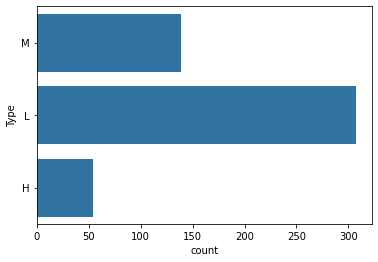

In [11]:
sns.countplot(df['Type'])

Type_percentage = df['Type'].value_counts()
print("percentage of individual of class M = ",Type_percentage[1]/500)
print("percentage of individual of class L = ",Type_percentage[0]/500)
print("percentage of individual of class H = ",Type_percentage[2]/500)

percentage of individual of class 'No Failure' =  0.934
percentage of individual of class 'Power Failure' =  0.012
percentage of individual of class 'Tool Wear Failure' =  0.038
percentage of individual of class 'Overstrain Failure' =  0.016


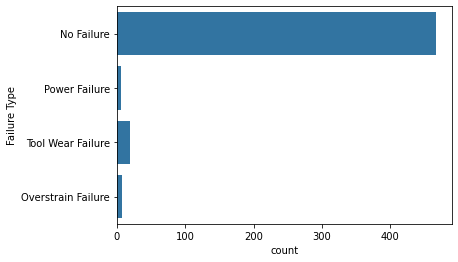

In [12]:
sns.countplot(df['Failure Type'])

Type_percentage = df['Failure Type'].value_counts()
print("percentage of individual of class 'No Failure' = ",Type_percentage[0]/500)
print("percentage of individual of class 'Power Failure' = ",Type_percentage[3]/500)
print("percentage of individual of class 'Tool Wear Failure' = ",Type_percentage[1]/500)
print("percentage of individual of class 'Overstrain Failure' = ",Type_percentage[2]/500)

It's clear that the "No Failure" class is significantly overrepresented, so we will need to apply oversampling techniques during the machine learning phase to address this class imbalance.

<AxesSubplot:>

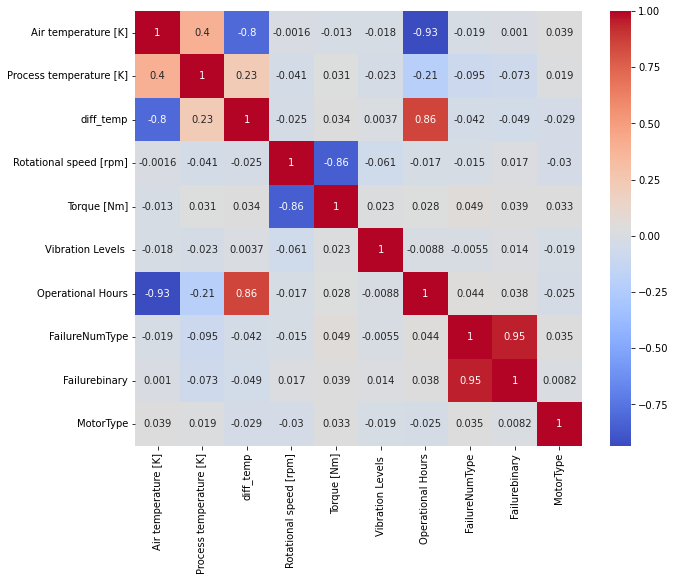

In [13]:
plt.figure(figsize=(10,8))
sns.heatmap(df_num.corr(),annot=True,cmap="coolwarm")

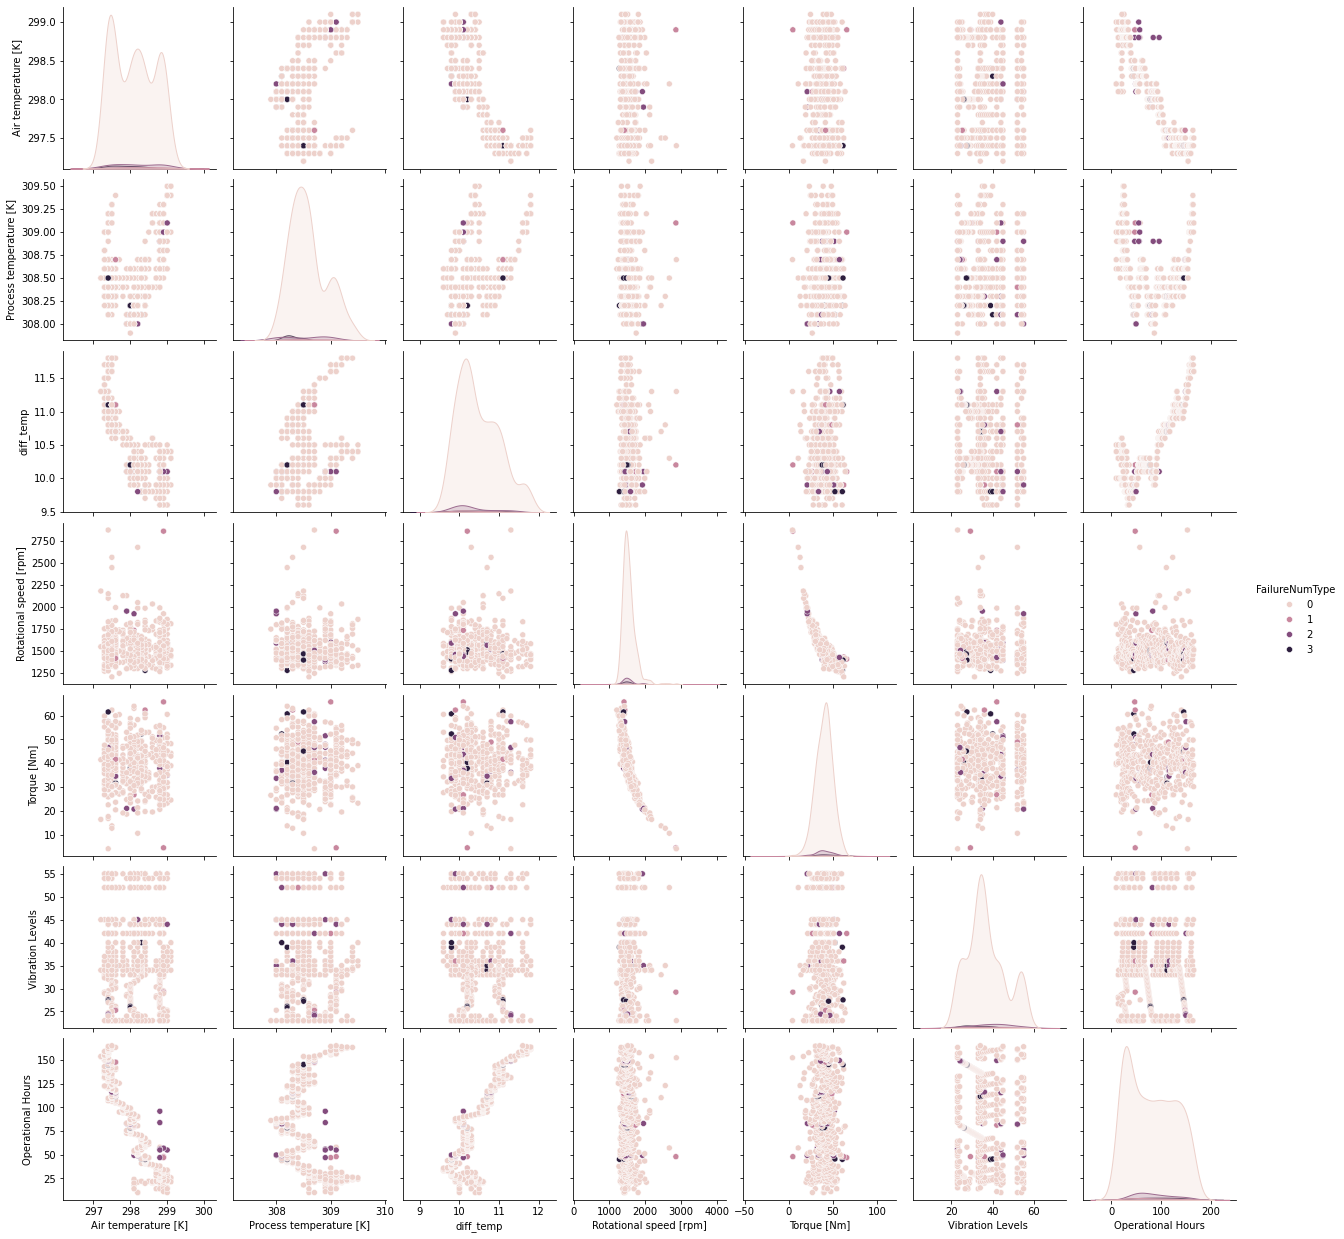

In [14]:
df_non_categorical_var = df_num[['Air temperature [K]','Process temperature [K]','diff_temp','Rotational speed [rpm]','Torque [Nm]','Vibration Levels ' ,'Operational Hours','FailureNumType']]
sns.pairplot(data=df_non_categorical_var, hue="FailureNumType")


## **Preparing the data for machine learning**

In [15]:
X = df_num.drop(columns=['Failurebinary','FailureNumType'])
y = df_num['Failurebinary']  # target (0 or 1)

ros = RandomOverSampler(random_state=0) #oversampling the data
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #splitting data between train and test

scaler = StandardScaler() #scale data to avoid bias because of differences between the standard deviation of the variables
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **Implementation of logistic regression model**

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np

#Estimate the accuracy of the backward on our logistic regression model with cross validation 
kf = KFold(n_splits=20, random_state=1, shuffle=True)
cvScores_all = []
cvScores_selected = []
i = 1

for train_index, test_index in kf.split(X):
    #it apply the backward (deduce the best subset of variable for logistic regression) selection on each sample of our dataset
    print(f"Fold: {i} ==================================================================")
    X_t, X_validation = X.iloc[train_index], X.iloc[test_index]
    y_t, y_validation = y.iloc[train_index], y.iloc[test_index]

    print(f"Train size: {len(X_t)}, Validation size: {len(X_validation)}")

    
    model_for_selection = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    sfs = SequentialFeatureSelector(
        model_for_selection,
        n_features_to_select='auto',
        direction='backward',
        scoring='accuracy',
        cv=5,
        n_jobs=-1
    )
    
    #apply backward on our sample
    sfs.fit(X_t, y_t)
    
    #get the selected variable
    selected_features = X_t.columns[sfs.get_support()]
    print(f"Variables sélectionnées ({len(selected_features)}): {list(selected_features)}")

    # train the model on the selected variable
    model_s = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_s.fit(X_t[selected_features], y_t)

    # evaluate the accuracy of the model
    y_pred_s = model_s.predict(X_validation[selected_features])
    acc_s = 100 * accuracy_score(y_validation, y_pred_s)
    print(f'Accuracy for backward model: {acc_s:.2f} %')

    # train the model on all variable
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_t, y_t)

    # evaluate the accuracy of the model
    y_pred = model.predict(X_validation)
    acc = 100 * accuracy_score(y_validation, y_pred)
    print(f'Accuracy for all variable model: {acc:.2f} %')

    cvScores_all.append(acc)
    cvScores_selected.append(acc_s)
    i += 1

print("Mean accuracy over the 50 folds using selected variables :", np.mean(cvScores_selected))
print("Mean accuracy over the 50 folds using all variables :", np.mean(cvScores_all))


Fold: 1 ==================================================================
Train size: 887, Validation size: 47
Variables sélectionnées (4): ['Air temperature [K]', 'diff_temp', 'Rotational speed [rpm]', 'Operational Hours']
Accuracy for backward model: 65.96 %
Accuracy for all variable model: 63.83 %
Fold: 2 ==================================================================
Train size: 887, Validation size: 47
Variables sélectionnées (4): ['diff_temp', 'Rotational speed [rpm]', 'Torque [Nm]', 'Operational Hours']
Accuracy for backward model: 61.70 %
Accuracy for all variable model: 72.34 %
Fold: 3 ==================================================================
Train size: 887, Validation size: 47
Variables sélectionnées (4): ['Air temperature [K]', 'diff_temp', 'Rotational speed [rpm]', 'Operational Hours']
Accuracy for backward model: 72.34 %
Accuracy for all variable model: 70.21 %
Fold: 4 ==================================================================
Train size: 887, Validat

In general, the model using all variables achieves higher accuracy than the one with backward selection. Therefore, we will retain all variables for our final logistic regression model.

### **Further performance indicators of the logistic regression model**

Classification Report:
               precision    recall  f1-score   support

  No failure       0.74      0.71      0.73        93
     Failure       0.72      0.76      0.74        94

    accuracy                           0.73       187
   macro avg       0.73      0.73      0.73       187
weighted avg       0.73      0.73      0.73       187



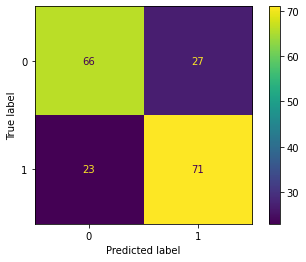

<Figure size 432x288 with 0 Axes>

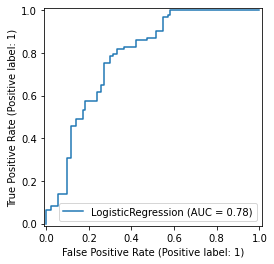

In [17]:
model = LogisticRegression(max_iter=500, solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['No failure','Failure']))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()

plt.figure()

RocCurveDisplay.from_estimator(
   model, X_test, y_test)
plt.show()

print("")

We observe an area under the roc curve of 0.78 and an accuracy of 0.73 which shows us that the model is somewhat accurate but still largely inefficient considering that the data considered are failures of motor that need a good accuracy.

## **Neural Network** 

We’re using a simple neural network to predict motor failures and applying 5-Fold cross-validation to evaluate its performance.

In [18]:
nb_split = 5
kf = KFold(n_splits=nb_split, random_state=1, shuffle=True)
cvScores = []
c_matrix = []
i = 1

for train_index, test_index in kf.split(X):
    #it apply the backward (deduce the best subset of variable for logistic regression) selection on each sample of our dataset
    print(f"Fold: {i} ==================================================================")
    X_t, X_validation = X.iloc[train_index], X.iloc[test_index]
    y_t, y_validation = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler() #scale data to avoid bias because of differences between the standard deviation of the variables
    X_t = scaler.fit_transform(X_t)
    X_validation = scaler.transform(X_validation)

    print(f"Train size: {len(X_t)}, Validation size: {len(X_validation)}")

    model = Sequential([
    Dense(24, input_dim = (8), activation = 'relu'),
    Dense(12, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
    ])

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()

    history = model.fit(X_t, y_t, epochs=150, batch_size=32, verbose = 1)

    scores = model.evaluate(X_validation, y_validation)
    y_pred_prob = model.predict(X_validation)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # evaluate the accuracy of the model
    acc = 100 * accuracy_score(y_validation, y_pred)

    confusion_matrix = metrics.confusion_matrix(y_validation, y_pred)
    #print(confusion_matrix)
    c_matrix.append(confusion_matrix)

    cvScores.append(acc)
    i += 1

    if i == nb_split:
        fpr, tpr, thresholds = roc_curve(y_validation, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        

Fold: 1 ==================================================================
Train size: 747, Validation size: 187
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                216       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
24/24 [==============================] - 0s 740us/step - loss: 0.7058 - accuracy: 0.5234
Epoch 2/150
24/24 [==============================] - 0s 170us/step - loss: 0.6666 - accuracy: 0.5663
Epoch 3/150
24/24 [==============================] - 0s 638us/step - loss

Mean accuracy over the 5 folds : 95.93295382669197



Text(0.5, 1.0, 'ROC Curve - Last Fold')

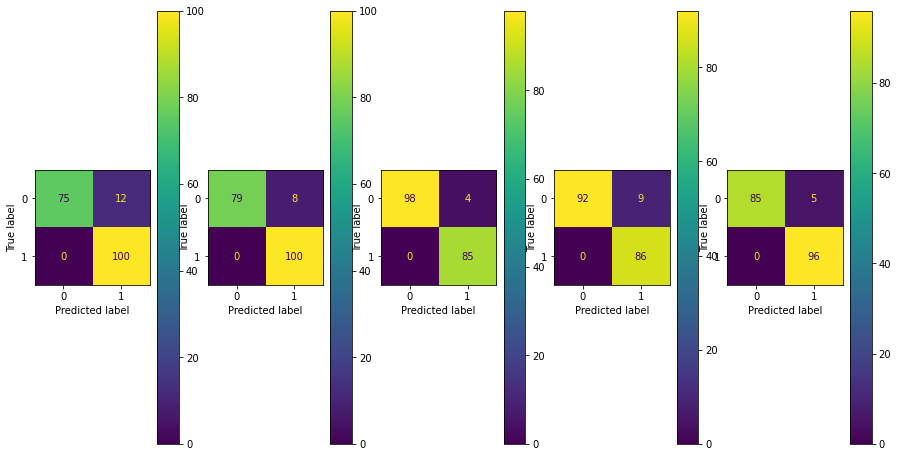

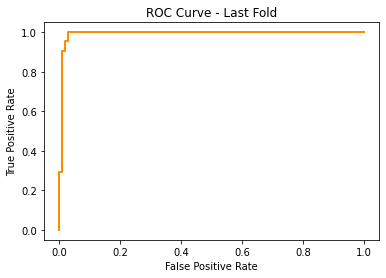

In [19]:
print("Mean accuracy over the 5 folds :", np.mean(cvScores))
print("")

count = 0
figure, ax = plt.subplots(1,5, figsize=(15, 15))
for i in c_matrix:
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = i, display_labels = [0, 1]).plot(ax=ax[count])
    count += 1

plt.plot()
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Last Fold')

The neural network achieved an accuracy of 95.93% through cross-validation, which is a strong result given the limited dataset of just 500 samples.

## **PCA visualisation of our predictions**

In [20]:
global_scaler = StandardScaler()
df_pca_normalized = global_scaler.fit_transform(X)

# If you want to transform the *last fold's* X_validation:
X_validation_pca = global_scaler.transform(X.iloc[test_index])

pca_engine = PCA(n_components=2)

principalComponents_engine = pca_engine.fit_transform(df_pca_normalized) #full df pca

X_test_pca = pca_engine.transform(X_validation_pca) #last test data (of our neural network cross-validation) pca

In [21]:
print('Explained variability per principal component: {}'.format(pca_engine.explained_variance_ratio_))

Explained variability per principal component: [0.35154439 0.22534001]


In [22]:
dim1_pca = [x[0] for x in principalComponents_engine]
dim2_pca = [x[1] for x in principalComponents_engine]

dim1_pca_test = [x[0] for x in X_test_pca]
dim2_pca_test = [x[1] for x in X_test_pca]

color = y.copy()
color_failure = color.replace({0: "blue", 1: "red"})

color_predict = ["green" if x == 0 else "red" for x in y_pred.flatten()-y_validation]


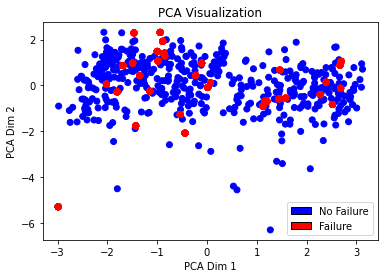

In [23]:
plt.scatter(dim1_pca,dim2_pca, color=color_failure)

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='No Failure'),
    Patch(facecolor='red', edgecolor='black', label='Failure')
]

plt.legend(handles=legend_elements)

plt.title("PCA Visualization")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")

plt.show()

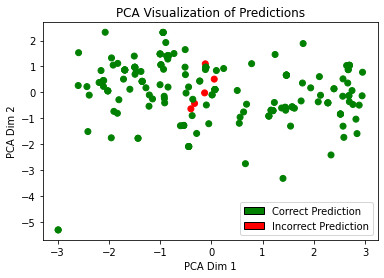

In [24]:
plt.scatter(dim1_pca_test,dim2_pca_test, color=color_predict)

legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Correct Prediction'),
    Patch(facecolor='red', edgecolor='black', label='Incorrect Prediction')
]

plt.legend(handles=legend_elements)

plt.title("PCA Visualization of Predictions")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")

plt.show()